# Определение перспективного тарифа для телеком компании
### В проводимом иследовании предстоит сделать предварительный анализ тарифов на небольшой выборке клиентов. В распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import random
import math as mt
from scipy import stats as st 
from math import factorial
import numpy as np
import datetime
from functools import reduce
import seaborn as sns

## Откроем файлы с данными

In [2]:
data_calls = pd.read_csv('/datasets/calls.csv')
data_internet = pd.read_csv('/datasets/internet.csv')
data_messagers = pd.read_csv('/datasets/messages.csv')
data_tariffs = pd.read_csv('/datasets/tariffs.csv')
data_users = pd.read_csv('/datasets/users.csv')

## Изучим общюю информацию 

In [3]:
print(data_calls.info())
data_calls.columns = data_calls.columns.str.replace('call_date','month') 
data_calls.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null object
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB
None


,id,month,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


### Таблица data_calls (информация о звонках): id — уникальный номер звонка; call_date — дата звонка; duration — длительность звонка в минутах;  user_id — идентификатор пользователя, сделавшего звонок

In [4]:
print(data_internet.info())
data_internet.columns = data_internet.columns.str.replace('session_date','month') 
data_internet.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 4 columns):
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null object
user_id         149396 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 4.6+ MB
None


,id,mb_used,month,user_id
0,1000_0,112.95,2018-11-25,1000
1,1000_1,1052.81,2018-09-07,1000
2,1000_2,1197.26,2018-06-25,1000
3,1000_3,550.27,2018-08-22,1000
4,1000_4,302.56,2018-09-24,1000


### Таблица data_internet (информация об интернет-сессиях): id — уникальный номер сессии; mb_used — объём потраченного за сессию интернет-трафика (в мегабайтах); session_date — дата интернет-сессии; user_id — идентификатор пользователя

In [5]:
print(data_messagers.info())
data_messagers.columns = data_messagers.columns.str.replace('message_date','month') 
data_messagers.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null object
user_id         123036 non-null int64
dtypes: int64(1), object(2)
memory usage: 2.8+ MB
None


,id,month,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


### Таблица data_messages (информация о сообщениях): id — уникальный номер сообщения; message_date — дата сообщения; user_id — идентификатор пользователя, отправившего сообщение

In [6]:
print(data_tariffs.info())
data_tariffs.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
messages_included        2 non-null int64
mg_per_month_included    2 non-null int64
minutes_included         2 non-null int64
rub_monthly_fee          2 non-null int64
rub_per_gb               2 non-null int64
rub_per_message          2 non-null int64
rub_per_minute           2 non-null int64
tariff_name              2 non-null object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes
None


,messages_included,mg_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


### Таблица data_tariffs (информация о тарифах): tariff_name — название тарифа; rub_monthly_fee — ежемесячная абонентская плата в рублях; minutes_included — количество минут разговора в месяц, включённых в абонентскую плату ; messages_included — количество сообщений в месяц, включённых в абонентскую плату; mb_per_month_included — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах); rub_per_minute — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата); rub_per_message — стоимость отправки сообщения сверх тарифного пакета; rub_per_gb — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)

In [7]:
print(data_users.info())
data_users.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null object
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null object
tariff        500 non-null object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB
None


,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


### Таблица data_users (информация о пользователях): user_id — уникальный идентификатор пользователя; first_name — имя пользователя; last_name — фамилия пользователя; age — возраст пользователя (годы); reg_date — дата подключения тарифа (день, месяц, год); churn_date — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных); city — город проживания пользователя; tariff — название тарифного плана

### изучая полученую информации можно отметить, что в основном предоставленны данные хорошего качества позволяющее не производить предобработку. За исключением data_users где имеются пропуски в столбце "churn_date — дата прекращения пользования тарифом". А также нулевые значения data_calls в столбце "duration — длительность звонка в минутах". 

### NaN в churn_date - отсутствие значений показывает на действие тарифа на момент выгрузки, заменим на индикаторные значения (-1)

### Нулевые значения в duration указывают на длительность звонка равную 0.0 минут, но при этом учтеную в тарификации, вероятнее всего это был так называемый "недозвон" обработанный оператором связи эквивалентно 1 минуте разговора, поэтому заменим нулевые значения на (1)
### Переведем имеющиеся данные со значением даеы в формат даты и выделим обозначение месяца
### Переведем данные об интернет трафике из мегобайтов в гигабайты и вследствии того, что при тарификации услуг оператор связи округляет в верх значение использованных минут и гигабайтов - округлим указанные значения в данных

In [8]:
# заполнение пропусков churn_date на -1
data_users['churn_date'] = data_users['churn_date'].fillna(-1)
# заменна нулевых значений duration на 1
data_calls['duration'] = data_calls['duration'].replace(0, 1)

In [9]:
# приведем разное наименование столбцов содержащих наименование месяца к одному названию
data_messagers.columns = data_messagers.columns.str.replace('message_date','month') 
data_internet.columns = data_internet.columns.str.replace('session_date','month') 
data_calls.columns = data_calls.columns.str.replace('call_date','month') 

In [10]:
# переведем значения во всех таблицах, где используются даты - в формат даты 
data_users['reg_date'] = pd.to_datetime(data_users['reg_date'], format='%Y.%m.%d')
data_messagers['month'] = pd.to_datetime(data_messagers['month'], format='%Y.%m.%d')
data_internet['month'] = pd.to_datetime(data_internet['month'], format='%Y.%m.%d')
data_calls['month'] = pd.to_datetime(data_calls['month'], format='%Y.%m.%d')

In [11]:
# для дальнейшей обработки информации будет использоватся только месяц - оставим в столбце дата только месяц
data_users['reg_date'] =  data_users['reg_date'].dt.strftime('%m')
data_messagers['month'] =  data_messagers['month'].dt.strftime('%m')
data_internet['month'] =  data_internet['month'].dt.strftime('%m')
data_calls['month'] =  data_calls['month'].dt.strftime('%m')

In [12]:
# переведем мегабайты в гигабайты (/1024)
#for n in range(len(data_internet['user_id'])):
data_internet['mb_used'] = data_internet['mb_used'] / 1024

In [13]:
# округлим в большую сторону
data_calls['duration'] = np.ceil(data_calls['duration'])
data_internet['mb_used'] = np.ceil(data_internet['mb_used'])

## Посчитаем для каждого пользователя :
## - количество сделанных звонков и израсходованных минут разговора по месяцам
## - количество отправленных сообщений по месяцам
## - объем израсходованного интернет-трафика по месяцам
## - помесячную выручку с каждого пользователя (вычтите бесплатный лимит из суммарного количества звонков, сообщений и интернет-трафика; остаток умножьте на значение из тарифного плана; прибавьте абонентскую плату, соответствующую тарифному плану)

In [14]:
# подсчет количества использованных минут по месяцам для каждого пользователя
data_calls_count = data_calls.pivot_table(index=('user_id','month'), values='duration', 
                                        aggfunc=('count')).reset_index()
data_calls_count.head(5)

,user_id,month,duration
0,1000,05,22
1,1000,06,43
2,1000,07,47
3,1000,08,52
4,1000,09,58


In [15]:
# подсчет суммы использованных минут по месяцам для каждого пользователя
data_calls_sum = data_calls.pivot_table(index=('user_id', 'month'), values='duration', 
                                        aggfunc=('sum')).reset_index()
data_calls_sum.head(5)

,user_id,month,duration
0,1000,05,164.0
1,1000,06,187.0
2,1000,07,346.0
3,1000,08,418.0
4,1000,09,478.0


In [16]:
# подсчет суммы отправленных сообщений по месяцам для каждого пользователя
data_messagers_count = data_messagers.pivot_table(index=('user_id','month'), values='id',
                                                  aggfunc=('count')).reset_index()
data_messagers_count.head(5)

,user_id,month,id
0,1000,05,22
1,1000,06,60
2,1000,07,75
3,1000,08,81
4,1000,09,57


In [17]:
# подсчет суммы использованных интернее-трафика по месяцам для каждого пользователя
data_internet_sum = data_internet.pivot_table(index=('user_id','month'), values='mb_used', 
                                              aggfunc=('sum')).reset_index()
data_internet_sum.head(5)

,user_id,month,mb_used
0,1000,05,4.0
1,1000,06,49.0
2,1000,07,28.0
3,1000,08,27.0
4,1000,09,26.0


In [18]:
# объеденим таблицы
dfs = [data_calls_sum, data_messagers_count, data_internet_sum, data_users]
data_main = reduce(lambda left,right: pd.merge(left, right, how='outer'), dfs)
data_main.head(5)

,user_id,month,duration,id,mb_used,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,05,164.0,22.0,4.0,52,-1,Краснодар,Рафаил,Верещагин,05,ultra
1,1000,06,187.0,60.0,49.0,52,-1,Краснодар,Рафаил,Верещагин,05,ultra
2,1000,07,346.0,75.0,28.0,52,-1,Краснодар,Рафаил,Верещагин,05,ultra
3,1000,08,418.0,81.0,27.0,52,-1,Краснодар,Рафаил,Верещагин,05,ultra
4,1000,09,478.0,57.0,26.0,52,-1,Краснодар,Рафаил,Верещагин,05,ultra


In [19]:
# создадим функцию для обработки таблиц в соответствии с тарифным планом
def rub_pack(row):
    try:
        if row['tariff'] == 'ultra':
            call, mg, messeng, rub_ms, rub_mg,  price = 3000, 30, 1000, 1, 150, 1950
        elif row['tariff'] == 'smart':
            call, mg, messeng, rub_ms, rub_mg,  price = 500, 15, 50, 3, 200, 550
        minut = row['duration'] - call
        sms = row['id'] - messeng
        mg_lim = row['mb_used'] - mg
        
        call_pay = max(minut * rub_ms, 0)
        sms_pay = max(sms * rub_ms, 0)
        mb_pay = max(mg_lim * rub_mg, 0)
         
        return (call_pay + sms_pay + mb_pay + price)        
    except:
        0

In [20]:
# подсчет стоимости платежа в месяц с учетом расходов сверх тарифного лимита
data_main['revenue'] = data_main.apply(rub_pack, axis=1)

data_main.head(5)

,user_id,month,duration,id,mb_used,age,churn_date,city,first_name,last_name,reg_date,tariff,revenue
0,1000,05,164.0,22.0,4.0,52,-1,Краснодар,Рафаил,Верещагин,05,ultra,1950.0
1,1000,06,187.0,60.0,49.0,52,-1,Краснодар,Рафаил,Верещагин,05,ultra,4800.0
2,1000,07,346.0,75.0,28.0,52,-1,Краснодар,Рафаил,Верещагин,05,ultra,1950.0
3,1000,08,418.0,81.0,27.0,52,-1,Краснодар,Рафаил,Верещагин,05,ultra,1950.0
4,1000,09,478.0,57.0,26.0,52,-1,Краснодар,Рафаил,Верещагин,05,ultra,1950.0


## Расмотрим сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц? Посчитаем среднее количество, дисперсию и стандартное отклонение. Построим гистограммы и опишим распределения.

In [21]:
# среднее количество  по месяцам в соответствии с тарифным планом
data_mean = data_main.pivot_table(index = 'tariff',  values = ('duration', 'id', 'mb_used', 'revenue'), aggfunc ='mean')
data_mean

,duration,id,mb_used,revenue
tariff,,,,
smart,430.609987,38.716441,42.437163,6283.831854
ultra,560.113565,61.161006,38.555897,3828.789894


### расчитаем дисперсию параметров 

In [22]:
# расчет дисперсии использованных минут 
var_minut = np.var(data_main['duration'], ddof = 1)
print('дисперсия количества минут', '=', var_minut)

дисперсия количества минут = 59495.224385573696


In [23]:
# расчет дисперсии количества сообщений 
var_sms = np.var(data_main['id'], ddof = 1)
print('дисперсия количества сообщений', '=', var_sms)

дисперсия количества сообщений = 1228.5980170128298


In [24]:
# расчет дисперсии количества гигабайт по месяцам
var_mb = np.var(data_main['mb_used'], ddof = 1)
print('дисперсия объема интернет-трафика', '=', var_mb)

дисперсия объема интернет-трафика = 271.0360972877746


### расчитаем стандартное отклонение параметров 

In [25]:
# расчет стандартного отклонения количества минут
std_minut = np.std(data_main['duration'], ddof = 1)
print('стандартное отклонение количества минут', '=', std_minut)

стандартное отклонение количества минут = 243.91642910139058


In [26]:
# расчет стандартного отклонения количества сообщений по месяцам
std_sms = np.std(data_main['id'], ddof = 1)
print('стандартное отклонение количества сообщений', '=', std_sms)

стандартное отклонение количества сообщений = 35.051362555724275


In [27]:
# расчет стандартного отклонения гигабайт 
std_mb = np.std(data_main['mb_used'], ddof = 1)
print('стандартное отклонение объема интернет-трафика', '=', std_mb)

стандартное отклонение объема интернет-трафика = 16.46317397368365


### Расматривая средние показатели по сумме использованных минут, количествы отправленных сообщений и объема интернет трафика можно заметить:
### - Среднее количество минут разговора по тарифу smart составляет 430.6, а по тарифу ultra  560.1. Стандартное отколонение составило 243. 92. По тарифу ultra пользователи значительно активнее исползуют для связи звонки. 
### - Среднее количество сообщений по тарифу smart составило 38.7, а по тарифу ultra  61.2. Стандартное отколонение составило 35.05. Ситуация аналогична предыдущему параметру - пользователи тарифа ultpa более активны
### - Средний объём интернет-трафика по тарифу smart составил 42.4, а по тарифу ultra  38.6.Стандартное отколонение составило 16.46.  В данном случае показатели свидетельствуют о возникновении обратного соотношения по сравнению с использованием минут и сообщений 
### Рассматривая полученные данные можно предположить, что пользователи выбравшие тариф smart с большей вероятностью не выходят за границы лимита предусмотренного тарифным планом по показателям использованных минут и количества сообщений, в тоже время они значительно превысили порговое значение по использованным гигабайтам интернет трафика. Эта ситуация вероятно возникла по причине неверной оценки потребности по объему услуг пользователями на момент выбора тарифа.  Напротив пользователи тарифа ultra более взвешено подошли к выбору тарифа, отсутствует превышения лимита по показателям использованных минут и количества сообщений  при более активном использований услуг, а превышение объема гигабайтов включенных в тариф менеее значительно по сравнения с предыдущим тарифом. 

### построим гистограмы распределения параметров по месяцам

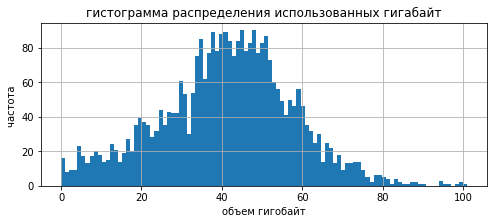

In [28]:
# построение гистограмм объема гигобайтов 
data_main['mb_used'].hist(bins=100, figsize = (8,3))
plt.ylabel('частота ')
plt.xlabel('объем гигобайт')
plt.title('гистограмма распределения использованных гигабайт')
plt.show()

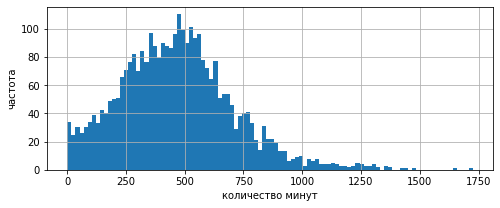

In [29]:
# построение сообщений количества минут по месяцам
data_main['duration'].hist(bins=100, figsize = (8,3))
plt.ylabel('частота')
plt.xlabel('количество минут')
plt.show()

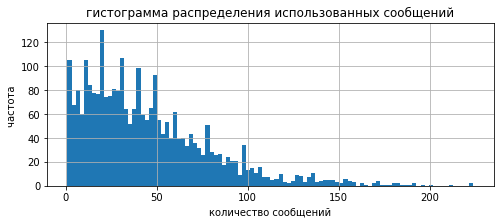

In [30]:
# построение гистограм сообщений 
data_main['id'].hist(bins=100, figsize = (8,3))
plt.ylabel('частота ')
plt.xlabel('количество сообщений')
plt.title('гистограмма распределения использованных сообщений')
plt.show()

### Расмотрим гистограммы распределения:
### Так для параметра количества минут и объема гигабайтов распределение близко к нормальному и в основном пользователи используют от 200 до 750 минут и 20 до 60 гигобайт. Для параметра количество сообщений распределение близко к распределению Пуасона, наибольшее рапостранение имеют количество сообщений от 1 до 75.

## Проверим гипотезы:
### средняя выручка пользователей тарифов «Ультра» и «Смарт» различается;
### средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов;


### Сформулируем нулевую гипотезу как то, что средняя выручка пользователей тарифов ultra и smart равна между собой. Альтернативной гипотезой установим неравенство средней выручки по тарифам. Пороговое значение alpha  примем равным 5%. Так как выборки средних независимы применим метод st.ttest_ind.

In [31]:
# проверка гипотезы
q = data_main.query('tariff == "smart"')['revenue']                 
w = data_main.query('tariff == "ultra"')['revenue'] 
alpha = 0.05
results = st.ttest_ind(q, w)
print('p-значение',results.pvalue)
if (results.pvalue < alpha):
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')


p-значение nan
Не получилось отвергнуть нулевую гипотезу


### На основании проведеного иследования у нас имеются основания отвергнуть нулевую гипотезу

### Сформулируем нулевую гипотезу как то, что средняя выручка пользователей тарифов проживающих в Москве и других регионах равна между собой. Альтернативной гипотезой установим неравенство средней выручки в зависимости от региона проживания. Пороговое значение alpha  примем равным 5%. Так как выборки средних независимы применим метод st.ttest_ind. 

In [32]:
# проверка гипотезы
q = data_main.query('city == "Москва"')['revenue']                 
w = data_main.query('city != "Москва"')['revenue'] 
alpha = 0.05
results = st.ttest_ind(q, w)
print('p-значение',results.pvalue)
if (results.pvalue < alpha):
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение nan
Не получилось отвергнуть нулевую гипотезу


### На основании проведеного иследования у нас нет достаточных оснований отвергнуть нулевую гипотезу

### На основании проведеного исследования можно сделать следующие выводы. Расматривая средние показатели по сумме использованных минут, количествы отправленных сообщений и объема интернет трафика можно заметить: Среднее количество минут разговора по тарифу smart составляет 430.6, а по тарифу ultra  560.1. Стандартное отколонение составило 243. 92. По тарифу ultra пользователи значительно активнее исползуют для связи звонки. Среднее количество сообщений по тарифу smart составило 38.7, а по тарифу ultra  61.2. Стандартное отколонение составило 35.05. Ситуация аналогична предыдущему параметру - пользователи тарифа ultpa более активны. Средний объём интернет-трафика по тарифу smart составил 42.4, а по тарифу ultra  38.6.Стандартное отколонение составило 16.46.  В данном случае показатели свидетельствуют о возникновении обратного соотношения по сравнению с использованием минут и сообщений. Рассматривая полученные данные можно предположить, что пользователи выбравшие тариф smart с большей вероятностью не выходят за границы лимита предусмотренного тарифным планом по показателям использованных минут и количества сообщений, в тоже время они значительно превысили порговое значение по использованным гигабайтам интернет трафика. Эта ситуация вероятно возникла по причине неверной оценки потребности по объему услуг пользователями на момент выбора тарифа.  Напротив пользователи тарифа ultra более взвешено подошли к выбору тарифа, отсутствует превышения лимита по показателям использованных минут и количества сообщений  при более активном использований услугб а превышение обема гигабайтов включенных в тариф менеее значительно по сравнения с предыдущим тарифом.  Распределение показателей: количесто минут и сообщений, объем гигобайтов. Так для параметра количества минут и объема гигабайтов распределение близко к нормальному и в основном пользователи используют от 200 до 750 минут и 20 до 60 гигобайт. Для параметра количество сообщений распределение близко к распределению Пуасона, наибольшее распостранение имеют количество сообщений от 1 до 75. Также была расмотрена гипотеза о различие средней выручки по тарифам и в зависимости от региона проживания. Исследование  дало возможности подтвердить гипотезу о разнице среденй выручки в зависимости от тарифа. Гипотиза о разнице расходов в зависимости от региона проживания не подтвердилась. 
### На основании проведенного анализа можно утверждать превышение выручки по тарифу smart над тарифом ultra в основном за счет дополнительных трат клиентов на сверхлимитный объем гигобайтов интернет трафика. Так среднее значение по выборочным данным для тарифа smart составило 6261.49, а для тарифф ultra 3842.49